## Tensorflow2 version
# Practical Deep Learning Guide for Genomic Prediction
## A Keras based guide to implement deep learning using tensorflow 2


In [ ]:
## Tensorflow 2 now incorporates keras
## Hyper - Parameter optimization with keras tuner

### M Perez-Enciso & LM Zingaretti
### miguel.perez@uab.es, m.lau.zingaretti@gmail.com

### thanks also to I Vourlaki (ibourlaki@gmail.com)

### If you find this resource useful, please cite: 
### Pérez-Enciso M, Zingaretti LM. 2019. A Guide on Deep Learning for Complex Trait Genomic Prediction. Genes, 10, 553.
### Zingaretti LM, Gezan SA, Ferrão LFV, Osorio LF, Monfort A, Muñoz PR, Whitaker VM, Pérez-Enciso M. 2020. Exploring Deep Learning for Complex Trait Genomic Prediction in Polyploid Outcrossing Species. Frontiers in Plant Science 11:25


In [1]:
# main modules needed
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

In [2]:
# DL modules
# tensorflow
import tensorflow as tf
print('tensorflow: %s' % tf.__version__)
# keras
from tensorflow import keras
print('keras: %s' % keras.__version__)
import kerastuner as kt
print('kerastuner: %s' % kt.__version__)

tensorflow: 2.4.1
keras: 2.4.0
kerastuner: 1.0.2


(479, 1279) (479,)
(120, 1279) (120,)
       min max mean sd
Train: -2.41866172921982 3.27892080508434 0.03656243695565241 0.9744612298270398
Test: -2.28909755016522 2.52690454198022 -0.14594506084797887 1.088160002689451


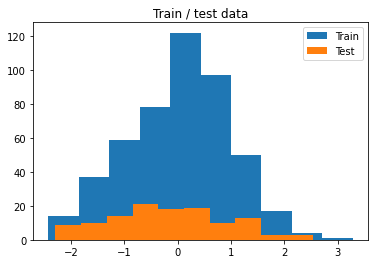

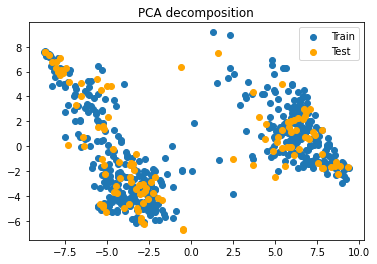

In [3]:
# DATA LOADING AND BASIC INSPECTION
# We use wheat data from BGLR (https://cran.r-project.org/web/packages/BGLR/BGLR.pdf)
'''
Matrix Y contains the average grain yield, column 1: Grain yield for environment 1 and so on.
Matrix X contains marker genotypes.
'''

# load the dataset as a pandas data frame
X = pd.read_csv('DATA/wheat.X', header=None, sep='\s+')
Y = pd.read_csv('DATA/wheat.Y', header=None, sep='\s+')

# data partitioning into train and validation
itrait=0 # first trait analyzed
X_train, X_test, y_train, y_test = train_test_split(X, Y[itrait], test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# print basic statistics: max, min, mean, sd
print('       min max mean sd')
print('Train:', y_train.min(), y_train.max(), y_train.mean(), np.sqrt(y_train.var()))
print('Test:', y_test.min(), y_test.max(), y_test.mean(), np.sqrt(y_test.var()))

# do basic histograms
plt.title('Train / test data')
plt.hist(y_train, label='Train')
plt.hist(y_test, label='Test')
plt.legend(loc='best')
plt.show()

# marker PCA, use whole X with diff color for train and test
X = np.concatenate((X_train, X_test))
pca = PCA(n_components=2)
p = pca.fit(X).fit_transform(X)
Ntrain=X_train.shape[0]
plt.title('PCA decomposition')
plt.scatter(p[0:Ntrain,0], p[0:Ntrain,1], label='Train')
plt.scatter(p[Ntrain:,0], p[Ntrain:,1], label='Test', color='orange')
plt.legend(loc='best')
plt.show()


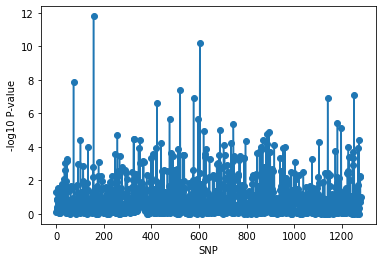

In [4]:
# OPTIONAL: SNP preselection according to a simple GWAS
pvals = []
for i in range(X_train.shape[1]):
    b, intercept, r_value, p_value, std_err = stats.linregress(X_train[i], y_train)
    pvals.append(-np.log10(p_value))
pvals = np.array(pvals)

# plot GWAS
plt.ylabel('-log10 P-value')
plt.xlabel('SNP')
plt.plot(pvals, marker='o')
plt.show()

# select N_best most associated SNPs
#N_best = X_train.shape[1] #all SNPs
N_best = 100
snp_list = pvals.argsort()[-N_best:]

# or select by min_P_value
min_P_value = 2 # P = 0.01
snp_list = np.nonzero(pvals>min_P_value)

# finally slice X
X_train = X_train[X_train.columns[snp_list]] 
X_test = X_test[X_test.columns[snp_list]] 



MSE in prediction = 0.7821123801773443

Corr obs vs pred = 0.44122221745754225


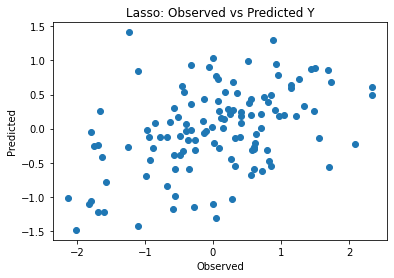

In [5]:
# Standard penalized methods (lasso using scikit-learn)
from sklearn.metrics import mean_squared_error

# alpha is the regularization parameter
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
y_hat = lasso.predict(X_test)

# mean squared error
mse = mean_squared_error(y_test, y_hat)
print('\nMSE in prediction =',mse)

# correlation btw predicted and observed
corr = np.corrcoef(y_test,y_hat)[0,1]
print('\nCorr obs vs pred =',corr)

# plot observed vs. predicted targets
plt.title('Lasso: Observed vs Predicted Y')
plt.ylabel('Predicted')
plt.xlabel('Observed')
plt.scatter(y_test, y_hat, marker='o')
plt.show()

# Exercises
# - Implement an internal crossvalidation to optimize alpha
# - try different sizes of most associated SNPs
# - implement ridge regression instead of lasso

In [5]:
# Implements a standard fully connected network (MLP) for a quantitative target
# Currently, there are two ways of specifying a model in keras
# 1. 'old' ways
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

# no. of SNPs (inut features) in data
nSNP = X_train.shape[1] 

print('\nThe "oldie" way:')
# Instantiate
model = Sequential()
# Add first layer that contains 64 neurons
model.add(Dense(64, input_dim=nSNP))
model.add(Activation('relu'))
# Add second layer (32 neurons)
model.add(Dense(32))
model.add(Activation('softplus'))
# Last, output layer, it is a single neuron since variable to predict is a float scalar
model.add(Dense(1))
# list some properties
model.summary()


The "oldie" way:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                10368     
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 12,481
Trainable params: 12,481
Non-trainable params: 0
_________________________________________________________________


In [6]:
# 2. 'New' way: adding layers is done recursively
# https://keras.io/getting_started/intro_to_keras_for_engineers/
from tensorflow.keras import layers
from tensorflow.keras import Model

# define input, 'None' if input dimension can vary
input = keras.Input(shape=(nSNP))
x = layers.Dense(64, activation='relu')(input)
x = layers.Dense(32, activation='softplus')(x)
output = layers.Dense(1, activation='linear')(x)

# instantiate
model = Model(inputs=input, outputs=output)

# summary
print('\nThe "new" sequential way:')
model.summary()


The "new" sequential way:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 161)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                10368     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 12,481
Trainable params: 12,481
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Once defined, a model needs to be compiled, trained and validated
# Model Compiling (https://keras.io/models/sequential/) 
# Stochastic Gradient Descent (‘sgd’) as optimization algorithm
# Mean Squared Error ('mse') as loss, ie, quantitative variable, regression
model.compile(optimizer='SGD', loss='mse') 

# training: this can take a while!
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
15/15 [==============================] - 0s 5ms/step - loss: 0.8945
Epoch 2/20
15/15 [==============================] - 0s 5ms/step - loss: 0.8381
Epoch 3/20
15/15 [==============================] - 0s 1ms/step - loss: 0.8624
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 0.8408
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 0.7929
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 0.7480
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6971
Epoch 8/20
15/15 [==============================] - 0s 3ms/step - loss: 0.7321
Epoch 9/20
15/15 [==============================] - 0s 6ms/step - loss: 0.6327
Epoch 10/20
15/15 [==============================] - 0s 5ms/step - loss: 0.6795
Epoch 11/20
15/15 [==============================] - 0s 2ms/step - loss: 0.7086
Epoch 12/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6861
Epoch 13/20
15/15 [==============================

1/1 [==============================] - 0s 213ms/step - loss: 1.3725

MSE in prediction = 1.372475028038025

Corr obs vs pred = 0.32896922412031954


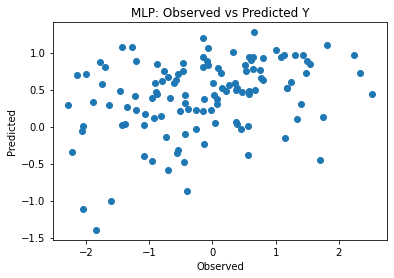

In [8]:
# cross-validation: get predicted target values
y_hat = model.predict(X_test, batch_size=128)

mse_prediction = model.evaluate(X_test, y_test, batch_size=128)
print('\nMSE in prediction =',mse_prediction)

# correlation btw predicted and observed
corr = np.corrcoef(y_test,y_hat[:,0])[0,1]
print('\nCorr obs vs pred =',corr)

# plot observed vs. predicted targets
plt.title('MLP: Observed vs Predicted Y')
plt.ylabel('Predicted')
plt.xlabel('Observed')
plt.scatter(y_test, y_hat, marker='o')
plt.show()

# Exercises
# - Check predictions across environments (Y[0] is first environment, etc)
# - Try to improve model with other activation functions and|or no. of neurons∫ 

In [10]:
# Controlling overfit: regularization, dropout and early stopping

# deletes current model if exists 
if 'model' in locals(): del model

# define input
input = keras.Input(shape=(nSNP))
x = layers.Dense(64, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(0.01),
                     activity_regularizer=keras.regularizers.l1(0.01))(input)
x = layers.Dense(32, activation='softplus')(x)
x = layers.Dropout(rate=0.2)(x)
output = Dense(1, activation='linear')(x)

# instantiate
model = Model(inputs=input, outputs=output)

# Model Compiling (https://keras.io/models/sequential/) 
model.compile(loss='mean_squared_error', optimizer='sgd')

In [11]:
# Controlling overfit: early stopping
# Split the train set into proper train & validation
X_train0, X_val, y_train0, y_val = train_test_split(X_train, y_train, test_size=0.1)

# This is the number of times all data are considered for parameter estimation
nEpochs=20

# Early stopping means not enough iteration to achieve convergence are allowed
early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01)
model.fit(X_train0, y_train0, epochs=nEpochs, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopper])

# cross-validation
mse_prediction = model.evaluate(X_test, y_test, batch_size=128)
print('\nMSE in prediction =',mse_prediction)

## In this case neither l1 nor l2 regularization helps

Epoch 1/20
14/14 [==============================] - 1s 55ms/step - loss: 3.4939 - val_loss: 2.2004
Epoch 2/20
14/14 [==============================] - 0s 17ms/step - loss: 2.0722 - val_loss: 2.1860
Epoch 3/20
14/14 [==============================] - 0s 16ms/step - loss: 2.0977 - val_loss: 2.0887
Epoch 4/20
14/14 [==============================] - 0s 15ms/step - loss: 2.0177 - val_loss: 2.0601
Epoch 5/20
14/14 [==============================] - 0s 11ms/step - loss: 1.9894 - val_loss: 2.1574
Epoch 6/20
14/14 [==============================] - 0s 13ms/step - loss: 2.0298 - val_loss: 2.0182
Epoch 7/20
14/14 [==============================] - 0s 11ms/step - loss: 1.8288 - val_loss: 2.0265
Epoch 8/20
14/14 [==============================] - 0s 14ms/step - loss: 1.7566 - val_loss: 2.0746
Epoch 9/20
14/14 [==============================] - 0s 12ms/step - loss: 1.8612 - val_loss: 1.9724
Epoch 10/20
14/14 [==============================] - 0s 17ms/step - loss: 1.7398 - val_loss: 1.9568
Epoch 11/

In [12]:
## We will use keras tuner to optimize hyperparameter search
# https://keras.io/keras_tuner/
# see also Chollet book 2nd ed. chapter 13
'''
To put the whole hyperparameter search space together and perform hyperparameter tuning, 
Keras Tuners uses `HyperModel` instances, i.e., a reusable class object 
I found defining a 'class' is much better than a function for using keras tuner,
and much more elegant!
'''
from kerastuner import HyperModel

class build_model(HyperModel):
    def __init__(self, input_dim):
        # input and output sizes, if needed, are defined
        self.input_dim = input_dim
        
    def build(self, hp):
        model = keras.Sequential()
        
        # first layer
        model.add(
            layers.Dense(
                input_dim=self.input_dim,
                # Define the hyperparameter search for # neurons, units is integer
                units=hp.Int("units", min_value=32, max_value=128, step=32),
                # choose activation function to use
                activation=hp.Choice("activation", ["relu", "tanh"])
            )
        )

        # second layer, dropout rate is float
        model.add(layers.Dense(32, activation="softplus"))
        model.add(
            layers.Dropout(
                rate=hp.Float("rate", min_value=0.0, max_value=0.5, step=0.10)
            )
        )
        
        # output layer
        model.add(layers.Dense(1))
       
        # options in compiling
        model.compile(loss='mse', optimizer='sgd', metrics=["mse"],)
        
        return model


In [13]:
hypermodel = build_model(input_dim=nSNP)

In [14]:
'''
After defining the search space, we need to select a tuner class to run the search. 
You may choose from RandomSearch, BayesianOptimization and Hyperband.

To initialize the tuner, we need to specify several arguments in the initializer.

hypermodel: The model-building function, which is build_model in our case.
objective: The name of the objective to optimize (whether to minimize or maximize is automatically inferred for built-in metrics). We will introduce how to use custom metrics later in this tutorial.
executions_per_trial: The number of models that should be built and fit for each trial. 
                      Different trials have different hyperparameter values. 
                      The executions within the same trial have the same hyperparameter values. The purpose of having multiple executions per trial is to reduce results variance and therefore be able to more accurately assess the performance of a model. If you want to get results faster, you could set executions_per_trial=1 (single round of training for each model configuration).
overwrite: Control whether to overwrite the previous results in the same directory 
           or resume the previous search instead. 
directory: A path to a directory for storing the search results.
project_name: The name of the sub-directory in the directory.

'''

tuner = kt.Hyperband(hypermodel,
                     objective="val_mse",
                     max_epochs=10,
                     overwrite=True)

# search summary
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}


In [15]:
# start search
'''
Then, start the search for the best hyperparameter configuration. 
All the arguments passed to search is passed to model.fit() in each execution. 
Remember to pass validation_data to evaluate the model.
'''

tuner.search(X_train0, y_train0, epochs=5, validation_data=(X_val, y_val),
            # Use the TensorBoard callback.
            # The logs will be write to "/tmp/tb_logs".
            callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],
)

Trial 30 Complete [00h 00m 03s]
val_mse: 0.805836021900177

Best val_mse So Far: 0.805836021900177
Total elapsed time: 00h 00m 58s
INFO:tensorflow:Oracle triggered exit


In [16]:
# click on HPARAMS, click on TABLE VIEW and in sorting by ascending validation.epoch_mse
%load_ext tensorboard

%tensorboard --logdir /tmp/tb_logs

In [17]:
'''
Query the results
When search is over, you can retrieve the best model(s). 
The model is saved at its best performing epoch evaluated on the validation_data.
'''
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]

# Build the model.
best_model.build()
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               20736     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 24,897
Trainable params: 24,897
Non-trainable params: 0
_________________________________________________________________


In [18]:
# print summary
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_mse', direction='min')
Trial summary
Hyperparameters:
units: 128
activation: relu
rate: 0.1
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.805836021900177
Trial summary
Hyperparameters:
units: 32
activation: tanh
rate: 0.0
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.8587983250617981
Trial summary
Hyperparameters:
units: 96
activation: tanh
rate: 0.2
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.8632120490074158
Trial summary
Hyperparameters:
units: 96
activation: relu
rate: 0.2
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.8777315616607666
Trial summary
Hyperparameters:
units: 96
activation: relu
rate: 0.4
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8842925429344177
Trial summary
Hyperparameters:
units: 64
activation: tanh
rat

N / class
Test  [86, 331, 61]
Train  [35, 71, 14]
All  [121, 402, 75]
1/1 [==============================] - 0s 188ms/step - loss: 2.4009

MSE in prediction = 2.400940179824829

Probabilities matrix
 [[0.23670393 0.62736833 0.13386099 0.00206673]
 [0.08689652 0.78197324 0.12901944 0.00211086]
 [0.03321762 0.58404362 0.35806727 0.02467138]
 [       nan        nan        nan        nan]]


/home/miguel/anaconda3/envs/tensor/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/miguel/anaconda3/envs/tensor/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


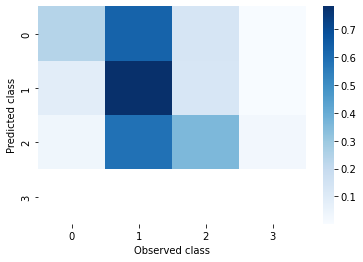

In [19]:
# MLP example with multiclass target

# Let us round class vector and make a few classes, all positive numbers
# just a trick to convert to classes
yi_train=[int(round(x-np.min(y_train))/2) for x in y_train]
yi_test=[int(round(x-np.min(y_test))/2) for x in y_test]

# N obs / clas; this may result in some very rare classes so consider merging
print('N / class')
print('Test ',[yi_train.count(i) for i in range(max(yi_train+yi_test))])
print('Train ',[yi_test.count(i) for i in range(max(yi_train+yi_test))])
print('All ',[(yi_test+yi_train).count(i) for i in range(max(yi_train+yi_test))])
# WARNING: make sure all clases in test are in train!!

# convert to classes, i need to make all classes equivalent
n_train=len(yi_train)
itemp = keras.utils.to_categorical(yi_train+yi_test)
i_train = itemp[:n_train,:]
i_test = itemp[n_train:,:]

# no. of SNPs in data
nSNP=X_train.shape[1]
nClasses=i_train.shape[1]

# Instantiate
model = Sequential()

# Add first layer
model.add(Dense(64, input_dim=nSNP))
model.add(Activation('relu'))
# Add second layer
model.add(Dense(32))
model.add(Activation('softplus'))
# Last, output layer
model.add(Dense(nClasses, activation='softmax'))

# Model Compiling 
model.compile(loss='categorical_crossentropy', optimizer='adam')

# training
model.fit(X_train, i_train, epochs=100, verbose=0)

# cross-validation: get predicted target values
i_hat = model.predict(X_test, batch_size=128)

mse_prediction = model.evaluate(X_test, i_test, batch_size=128)
print('\nMSE in prediction =',mse_prediction)

# do a heatplot, obs vs expected class distribution
# collect all results by class
# compute average prediction by class
heat = np.zeros([nClasses,nClasses])
for i in range(nClasses):
    iclass = np.nonzero(i_test[:,i]>0) # samples of i-th class
    for j in range(nClasses):
        heat[i,j] = np.mean(i_hat[iclass,j])

# plot observed vs. predicted targets
print('\nProbabilities matrix\n',heat)
plot = sns.heatmap(heat, cmap="Blues")
plot.set(xlabel='Observed class', ylabel='Predicted class')
plt.show()

In [21]:
#--> CNN example
nSNP = X_train.shape[1] 
nStride = 3  # stride between convolutions
nFilter = 32 # no. of convolutions

# Instantiate
model_cnn = Sequential()

#WARNING!!! I need this to match dimensions 
#https://stackoverflow.com/questions/43396572/dimension-of-shape-in-conv1d
X2_train = np.expand_dims(X_train, axis=2) 
X2_test = np.expand_dims(X_test, axis=2) 

# add convolutional layer
model_cnn.add(layers.Conv1D(nFilter, kernel_size=3, strides=nStride, input_shape=(nSNP,1)))
# add pooling layer: takes maximum of two consecutive values
model_cnn.add(layers.MaxPooling1D(pool_size=2))
# Solutions above are linearized to accommodate a standard layer
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64))
model_cnn.add(layers.Activation('relu'))
model_cnn.add(layers.Dense(32))
model_cnn.add(layers.Activation('softplus'))
model_cnn.add(layers.Dense(1))

# Model Compiling (https://keras.io/models/sequential/) 
model_cnn.compile(loss='mean_squared_error', optimizer='sgd')

# list some properties
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 53, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 26, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 832)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                53312     
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_3 (Activation)    (None, 32)               

In [22]:
# training (verbose = 0 means no stdout output)
model_cnn.fit(X2_train, y_train, epochs=20, verbose=1)

Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.2040
Epoch 2/20
15/15 [==============================] - 0s 27ms/step - loss: 0.9016
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 0.8343
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 0.8636
Epoch 5/20
15/15 [==============================] - 0s 7ms/step - loss: 0.8581
Epoch 6/20
15/15 [==============================] - 0s 5ms/step - loss: 0.8587
Epoch 7/20
15/15 [==============================] - 0s 7ms/step - loss: 0.7855
Epoch 8/20
15/15 [==============================] - 0s 6ms/step - loss: 0.8496
Epoch 9/20
15/15 [==============================] - 0s 16ms/step - loss: 0.8684
Epoch 10/20
15/15 [==============================] - 0s 8ms/step - loss: 0.7727
Epoch 11/20
15/15 [==============================] - 0s 6ms/step - loss: 0.8014
Epoch 12/20
15/15 [==============================] - 0s 6ms/step - loss: 0.7963
Epoch 13/20
15/15 [==========================

1/1 [==============================] - 0s 227ms/step - loss: 1.1180

MSE in prediction = 1.1180294752120972

Corr obs vs pred = 0.29499516966820555


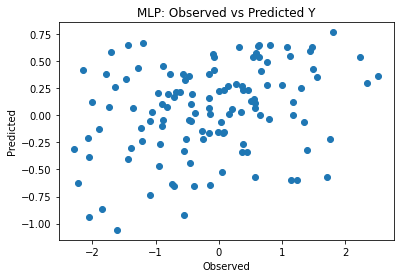

In [23]:
# cross-validation
mse_prediction = model_cnn.evaluate(X2_test, y_test, batch_size=128)
print('\nMSE in prediction =',mse_prediction)

# get predicted target values
y_hat = model_cnn.predict(X2_test, batch_size=128)

# correlation btw predicted and observed
corr = np.corrcoef(y_test,y_hat[:,0])[0,1]
print('\nCorr obs vs pred =',corr)

# plot observed vs. predicted targets
plt.title('MLP: Observed vs Predicted Y')
plt.ylabel('Predicted')
plt.xlabel('Observed')
plt.scatter(y_test, y_hat, marker='o')
plt.show()

In [24]:
print(X_train.shape)


(479, 161)


In [25]:
# If you find error  'str' object has no attribute 'decode': 
# reinstall h5py: pip install 'h5py==2.10.0' --force-reinstall
# save and reuse model
from tensorflow.keras.models import load_model

# creates a HDF5 file 'my_model.h5'
model_cnn.save('my_model.h5') 

model_cnn.summary()

# loads a compiled model, identical to the previous one
model_cnn_loaded = load_model('my_model.h5')
model_cnn_loaded.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 53, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 26, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 832)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                53312     
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_3 (Activation)    (None, 32)               